In [57]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = '../Data/features_3_sec.csv' 
df = pd.read_csv(data_path)

print(df.describe())


        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              2241.385959   
std                751.860611       

In [103]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

## EDA

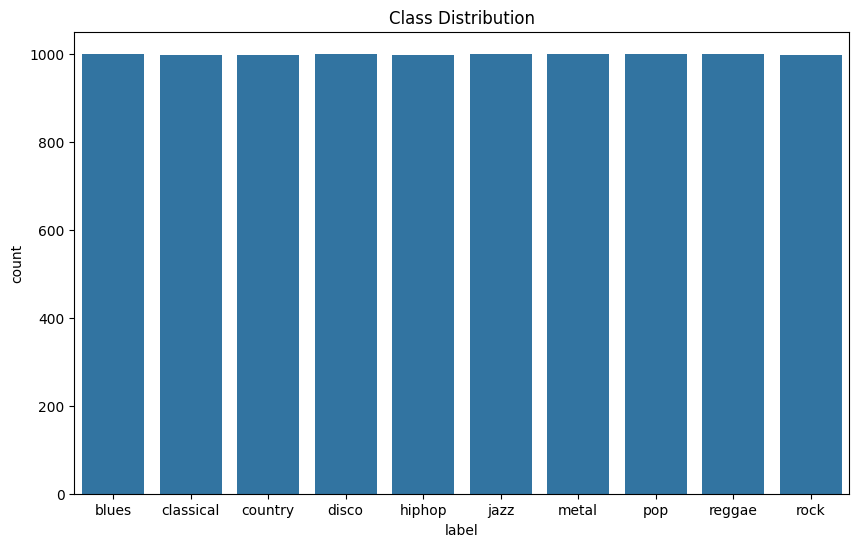

In [58]:

# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()


/var/folders/fp/tqnwc7rd219_w0rxtd8b8pz00000gn/T/ipykernel_57163/2966539110.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="tempo", data=x, palette='husl')


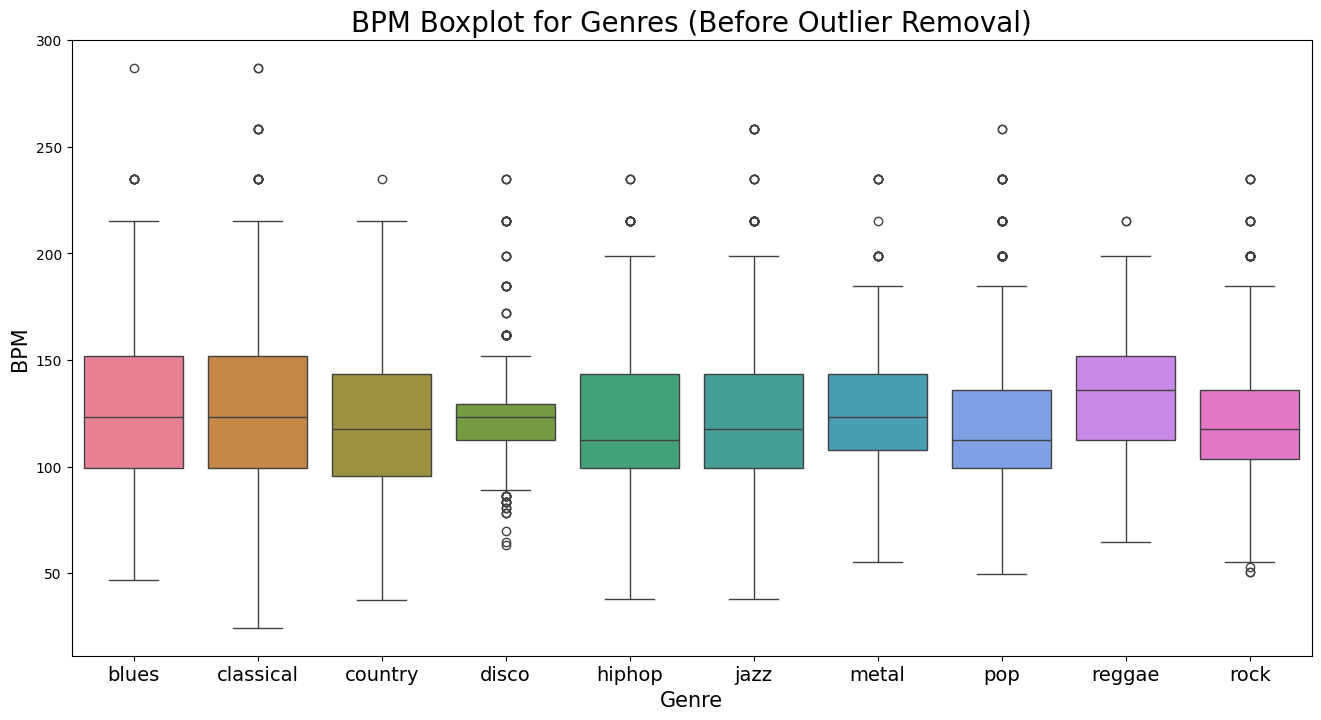

In [59]:

# Boxplot before removing outliers
x = df[["label", "tempo"]]
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="label", y="tempo", data=x, palette='husl')
plt.title('BPM Boxplot for Genres (Before Outlier Removal)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("BPM", fontsize=15)
plt.savefig("BPM_Boxplot_Before.png")
plt.show()


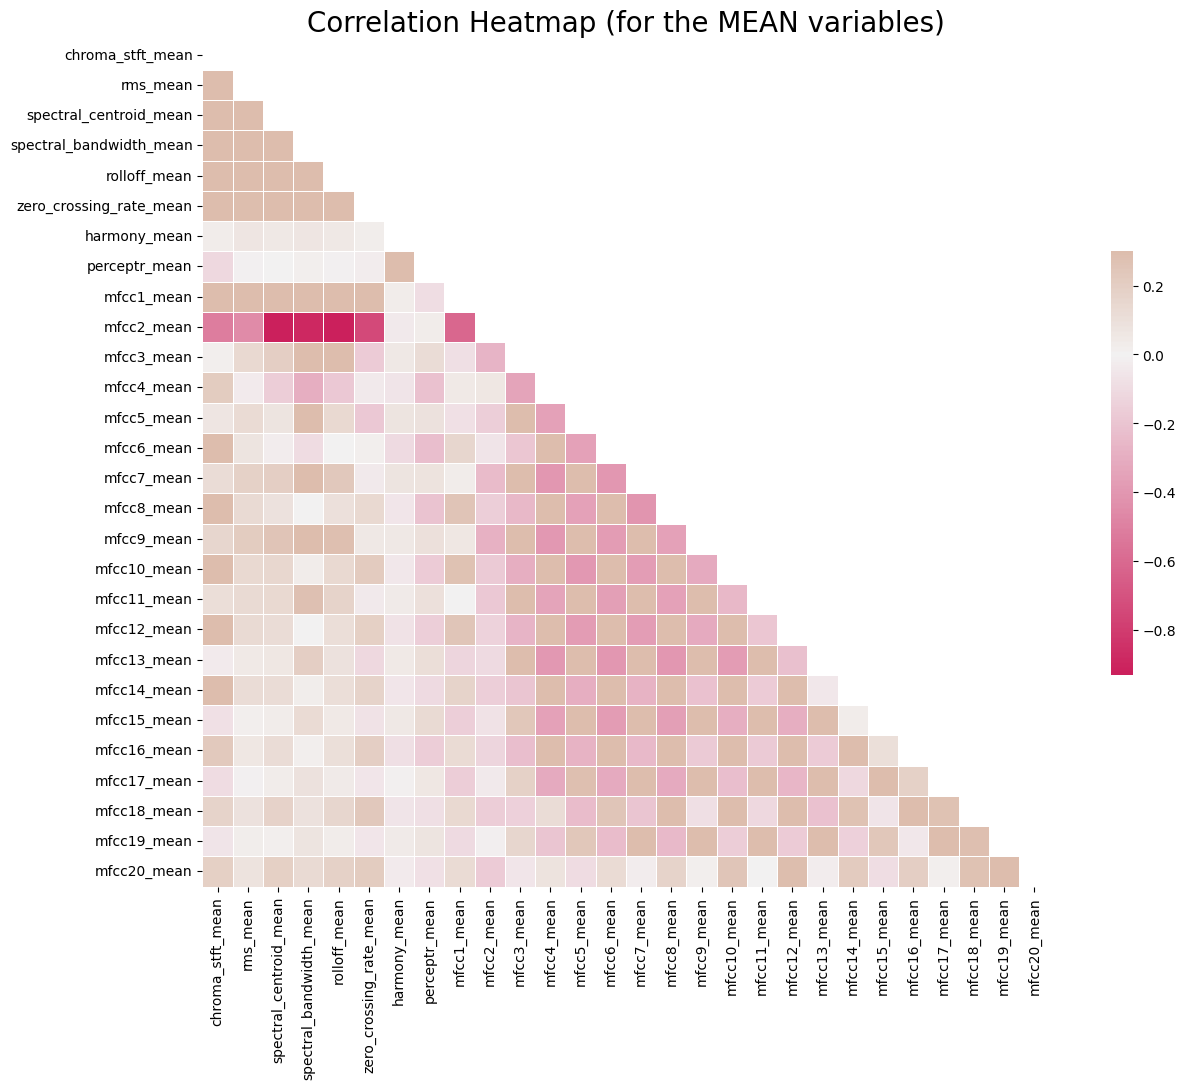

In [60]:

# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=90, l=45, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")
plt.show()


/var/folders/fp/tqnwc7rd219_w0rxtd8b8pz00000gn/T/ipykernel_57163/2622881641.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="tempo", data=x_no_outliers, palette='husl')


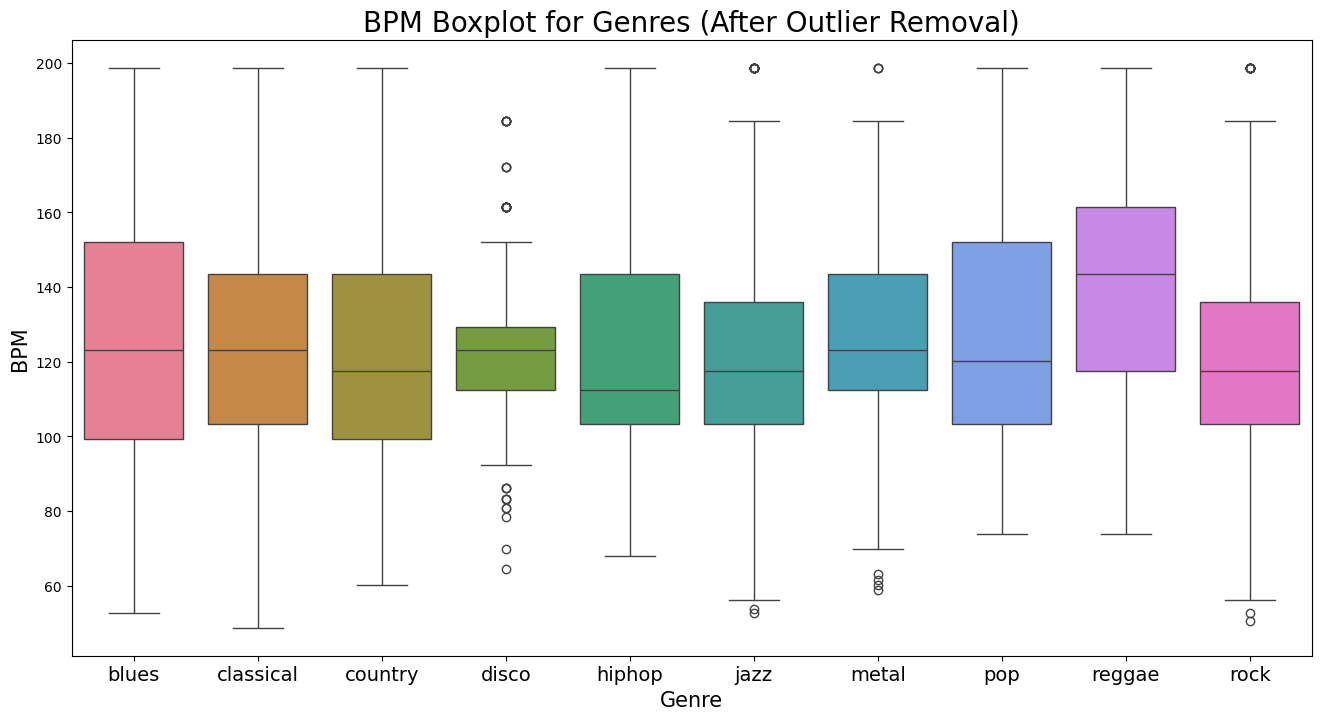

In [61]:

# Outlier removal
Q1 = df.drop(['filename', 'label'], axis=1).quantile(0.25)
Q3 = df.drop(['filename', 'label'], axis=1).quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df.drop(['filename', 'label'], axis=1) < (Q1 - 1.5 * IQR)) | (df.drop(['filename', 'label'], axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)]

# Boxplot after removing outliers
x_no_outliers = df_no_outliers[["label", "tempo"]]
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="label", y="tempo", data=x_no_outliers, palette='husl')
plt.title('BPM Boxplot for Genres (After Outlier Removal)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("BPM", fontsize=15)
plt.savefig("BPM_Boxplot_After.png")
plt.show()


## Missing Value Treatment

In [62]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

In [63]:

# Separate features and labels
X = df_no_outliers.drop(['filename', 'label'], axis=1)
y = df_no_outliers['label']

# Standardize features
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)


Accuracy: 0.8272859216255443
              precision    recall  f1-score   support

       blues       0.92      0.74      0.82        91
   classical       0.93      0.91      0.92        45
     country       0.80      0.87      0.84       119
       disco       0.75      0.93      0.83        92
      hiphop       0.94      0.80      0.87        61
        jazz       0.71      0.91      0.80        45
       metal       0.86      0.85      0.85        72
         pop       0.91      0.74      0.82        42
      reggae       0.78      0.72      0.75        40
        rock       0.80      0.74      0.77        82

    accuracy                           0.83       689
   macro avg       0.84      0.82      0.83       689
weighted avg       0.84      0.83      0.83       689



In [105]:
# Get feature importances
feature_importance = clf.feature_importances_
feature_names = df.columns[1:-1]

# Sort features by importance
sorted_idx = feature_importance.argsort()[::-1]

# Print the top 10 important features
top_n = 10
print(f"Top {top_n} Important Features:")
for i in range(top_n):
    print(f"{feature_names[sorted_idx[i]]}: {feature_importance[sorted_idx[i]]:.4f}")

Top 10 Important Features:
perceptr_var: 0.0467
mfcc4_mean: 0.0348
chroma_stft_mean: 0.0326
perceptr_mean: 0.0310
rms_mean: 0.0308
rms_var: 0.0290
mfcc9_mean: 0.0278
rolloff_mean: 0.0263
mfcc1_mean: 0.0254
spectral_centroid_mean: 0.0245


In [166]:
def extract_features_from_audio(audio_path):
    audio, sr = librosa.load(audio_path, mono=True)
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30), axis=1)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr))
    tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sr))
    additional_features = np.array([spectral_centroid, spectral_bandwidth, spectral_contrast, chroma, tonnetz])
    return np.concatenate((mfccs, additional_features))


In [182]:
audio_path = '../Test/gunsnroses.mp3'
#tiffany.mp3
#gunsnroses.mp3
#thislove.wav
#steal oned.mp3
#firework.mp3
input_features = extract_features_from_audio(audio_path)
print("Input Features:", input_features)


Input Features: [-1.40495773e+02  8.05558701e+01 -1.97298870e+01  3.02029743e+01
 -4.22674513e+00  4.24995613e+00 -2.70529604e+00  1.01194918e+00
 -4.93282986e+00 -2.21602082e+00 -1.73261237e+00 -1.81623590e+00
 -3.89838123e+00 -2.97680283e+00 -9.50782204e+00 -7.39929497e-01
 -7.48972797e+00  2.23447308e-01 -2.17042184e+00 -1.80300391e+00
 -5.91913366e+00 -1.06747389e+00 -6.78998613e+00  9.05892666e-05
 -7.24059391e+00 -9.65784907e-01 -4.31780100e+00 -3.64803940e-01
 -5.95783186e+00 -1.52655208e+00  2.39781335e+03  2.27864277e+03
  2.21607715e+01  3.56584430e-01 -2.12777245e-02]


In [183]:
num_expected_features = X.shape[1]

print("Number of Extracted Features:", len(input_features))
print("Number of Expected Features:", num_expected_features)


Number of Extracted Features: 35
Number of Expected Features: 58


In [184]:


# Ensure that the number of features extracted matches the model's expectations
num_expected_features = X.shape[1]
if len(input_features) != num_expected_features:
    input_features = input_features[:num_expected_features] if len(input_features) > num_expected_features else np.pad(input_features, (0, num_expected_features - len(input_features)))

# Predict the genre
predicted_genre = clf.predict(input_features.reshape(1, -1))
print(f"The predicted genre for the song is: {predicted_genre[0]}")


The predicted genre for the song is: metal
